In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gensim.models import KeyedVectors
from torch.utils.data import DataLoader, Dataset
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import nltk
from nltk.corpus import stopwords
from scipy.stats import chi2_contingency
from collections import Counter

nltk.download('stopwords')

c:\Users\gangmin\AppData\Local\miniconda3\envs\medical\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gangmin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
icd_10 = d_icd_diagnoses[d_icd_diagnoses['icd_version']==10]

- I5040	Unspecified combined systolic (congestive) and diastolic (congestive) heart failure
- I5041	Acute combined systolic (congestive) and diastolic (congestive) heart failure
- I5042	Chronic combined systolic (congestive) and diastolic (congestive) heart failure
- I5043	Acute on chronic combined systolic (congestive) and diastolic (congestive) heart failure
- I50810	Right heart failure, unspecified
- I50811	Acute right heart failure
- I50812	Chronic right heart failure
- I50813	Acute on chronic right heart failure
- I50814	Right heart failure due to left heart failure
- I5082	Biventricular heart failure
- I5083	High output heart failure
- I5084	End stage heart failure
- I5089	Other heart failure
- I509	Heart failure, unspecified
- R570	Cardiogenic shock
- R579	Shock, unspecified

In [5]:
icd_10[icd_10['icd_code'].str.startswith('I5040')]

,icd_code,icd_version,long_title
24793,I5040,10,Unspecified combined systolic (congestive) and...


In [6]:
heart_failure_code = ['I5040','I5041','I5042','I5043','I50810','I50811','I50812','I50813','I50814','I5082','I5083','I5084','I5089','I509','R570','R579']

In [7]:
heart_failure_df = icd_10[icd_10['icd_code'].isin(heart_failure_code)]

In [8]:
diagnoses_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
4756321,19999987,23865745,7,41401,9
4756322,19999987,23865745,8,78039,9
4756323,19999987,23865745,9,0413,9
4756324,19999987,23865745,10,36846,9


In [9]:
hf_patient = diagnoses_icd[diagnoses_icd['icd_code'].isin(heart_failure_code)][['subject_id', 'hadm_id']]

In [10]:
hf_note = note.merge(hf_patient,how='right', on=['subject_id', 'hadm_id'])
hf_note['text_length'] = hf_note['text'].apply(lambda x: len(x) if pd.notna(x) else 0)

# 'subject_id', 'hadm_id', 'note_id가 동일한 경우에는 text length가 가장 긴 행만 남김
hf_note_max_text = hf_note.loc[hf_note.groupby(['subject_id', 'hadm_id', 'note_id'])['text_length'].idxmax()]
hf_note_max_text = hf_note_max_text.drop(columns=['text_length'])

In [11]:
admission_time = admission[['subject_id', 'hadm_id', 'dischtime', 'deathtime']]

In [12]:
hf_note_max_text= hf_note_max_text.merge(admission_time, how='left', on=['subject_id', 'hadm_id'])

In [13]:
hf_note_max_text['dischtime'] = pd.to_datetime(hf_note_max_text['dischtime'])
admission['admittime'] = pd.to_datetime(admission['admittime'])
admission['dischtime'] = pd.to_datetime(admission['dischtime'])
hf_note_max_text['label'] = 0

admission_general = hf_note_max_text.copy()
admission_30days = hf_note_max_text.copy()

In [14]:
# 단순히 readmission이 있기만 하면 1로 라벨링함 / 논문에 따르면 scenario A
for idx, note_row in admission_general.iterrows():
    subject_id = note_row['subject_id']
    dischtime = note_row['dischtime']
    
    general_admissions = admission[admission['subject_id'] == subject_id]
    within_admission = general_admissions[
        (general_admissions['admittime'] > dischtime)]
    
    if not within_admission.empty:
        admission_general.at[idx, 'label'] = 1

In [15]:
# 30일 이내에 readmission 기록이 있는 경우에만 라벨링함 / 논문에 따르면 scenario B
for idx, note_row in admission_30days.iterrows():
    subject_id = note_row['subject_id']
    dischtime = note_row['dischtime']
    
    admissions_30days = admission[admission['subject_id'] == subject_id]
    within_30_days = admissions_30days[
        (admissions_30days['admittime'] > dischtime) & 
        (admissions_30days['admittime'] <= dischtime + pd.Timedelta(days=30))]
    
    if not within_30_days.empty:
        admission_30days.at[idx, 'label'] = 1

In [16]:
print("단순히 readmission한 환자: ", len(admission_general[admission_general['label']==1]))
print("30일 이내 readmission한 환자: ", len(admission_30days[admission_30days['label']==1]))

단순히 readmission한 환자:  2138
30일 이내 readmission한 환자:  889


In [17]:
admission_general['label'].value_counts()

label
0    2507
1    2138
Name: count, dtype: int64

In [18]:
admission_30days['label'].value_counts()

label
0    3756
1     889
Name: count, dtype: int64

In [19]:
pos_general_num = len(admission_general[admission_general['label']==1])
pos_30days_num = len(admission_30days[admission_30days['label']==1])
pos_general = admission_general[admission_general['label']==1]
pos_30days = admission_30days[admission_30days['label']==1]
neg_general = admission_general[admission_general['label']==0].sample(n=pos_general_num)
neg_30days = admission_30days[admission_30days['label']==0].sample(n=pos_30days_num)

general = pd.concat([pos_general, neg_general])
days_30 = pd.concat([pos_30days, neg_30days])

general = general[['text', 'label']].copy()
days_30 = days_30[['text', 'label']].copy()

## Text Preprocessing

In [26]:
tqdm.pandas()

In [27]:
def preprocess_text(text) : 

        # text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s\.\n]', '', text)
        text = re.sub(r'\s+', ' ', text) # 연속된 공백을 하나의 공백으로 변환
        text = text.strip() # 양쪽 끝의 공백 제거

        # 익명화되어 알 수 없는 개인 정보 단어 삭제
        anony_words = ['name', 'unit', 'no', 'admission date', 'discharge date', 'date of birth', 'date', 'birth', 'attending', 'followup instructions', 'sex', 'service', 'chief complaint', 'major surgical or invasive procedure', 'history of present illness', 'past medical history', 'allergies',
                       'medications', 'social history', 'physical examination','laboratory data', 'hospital course', 'discharge instructions','discharge medications', 'discharge condition', 'diagnosis', '.']
        for word in anony_words:
                text = re.sub(r'\b' + re.escape(word) + r'\b', '', text)

        # 숫자 제거
        text = re.sub(r'\d+', '', text)

        # 불용어 제거
        stop_words = list(stopwords.words('english'))
        text_words = text.split()
        text_words = [word for word in text_words if word not in stop_words]
        text = ' '.join(text_words)

        return text

general['text'] = general['text'].progress_apply(preprocess_text)
days_30['text'] = days_30['text'].progress_apply(preprocess_text)

100%|██████████| 1778/1778 [00:09<00:00, 196.46it/s]


In [28]:
general['text_length'] = general['text'].apply(len)
average_length = general['text_length'].mean()
average_length

9417.702993451825

In [29]:
print('최대 글자수: ', general['text_length'].max())
print('최소 글자수: ', general['text_length'].min())

최대 글자수:  38855
최소 글자수:  182


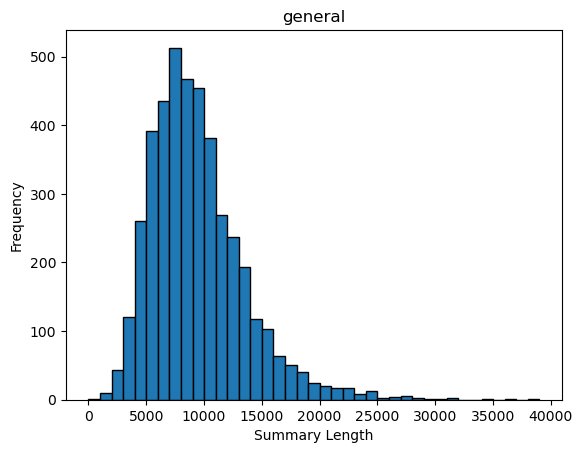

In [30]:
plt.hist(general['text_length'], bins=range(0,40000,1000), edgecolor='black')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('general')
plt.show()

In [31]:
lower_bound = general['text_length'].quantile(0.05)
upper_bound = general['text_length'].quantile(0.95)
print('lower bound', lower_bound)
print('upper_bound', upper_bound)

lower bound 4223.25
upper_bound 16917.75


In [32]:
filtered_general = general[(general['text_length'] >= lower_bound) & (general['text_length'] <= upper_bound)]

In [33]:
print("상, 하위 5%씩 제거한 후 글자수 평균: ", filtered_general['text_length'].mean())

상, 하위 5%씩 제거한 후 글자수 평균:  9129.252079002079


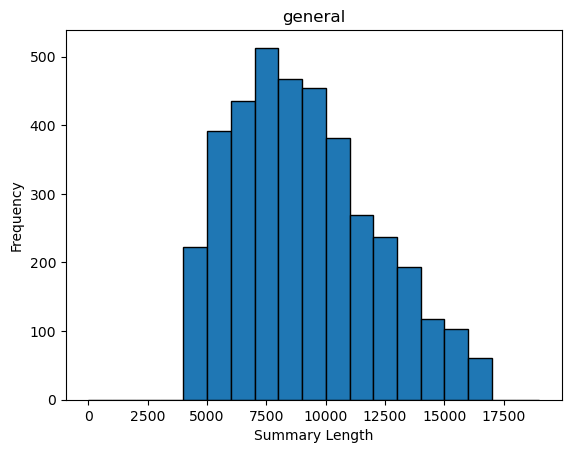

In [34]:
plt.hist(filtered_general['text_length'], bins=range(0,20000,1000), edgecolor='black')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('general')
plt.show()

In [35]:
# admission_general
X = filtered_general['text']
y = filtered_general['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=0)

In [36]:
# admission_30days
A = days_30['text']
b = days_30['label']

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size = 0.1, random_state=0)

---

## word2vec Embedding

In [37]:
def calculate_length(texts):
    lengths = []
    for text in texts : 
        parts = text.split(',')
        for part in parts : 
            word_count = len(part.split())
            lengths.append(word_count)

    avg_length = np.mean(lengths)
    max_length = np.max(lengths)
    min_length = np.min(lengths)

    return avg_length, max_length, min_length

# 각 행의 평균 길이 계산
general['length'] = general['text'].apply(calculate_length)
days_30['length'] = days_30['text'].apply(calculate_length)

In [38]:
avg_length = general['length'].apply(lambda x: x[0])
max_length = general['length'].apply(lambda x: x[1])
min_length = general['length'].apply(lambda x: x[2])

average = avg_length.mean()
max_average = max_length.mean()
min_average = min_length.mean()

print(f"전체 평균: {average}")
print(f"최대 길이: {max_average}")
print(f"최소 길이: {min_average}")

전체 평균: 0.8608037640377574
최대 길이: 1.0
최소 길이: 0.0


In [39]:
avg_length = days_30['length'].apply(lambda x: x[0])
max_length = days_30['length'].apply(lambda x: x[1])
min_length = days_30['length'].apply(lambda x: x[2])

# 각 리스트의 전체 평균 계산
average = avg_length.mean()
max_average = max_length.mean()
min_average = min_length.mean()

print(f"전체 평균: {average}")
print(f"최대 길이: {max_average}")
print(f"최소 길이: {min_average}")

전체 평균: 0.8606459642325579
최대 길이: 1.0
최소 길이: 0.0


In [40]:
word2vec_path = "C:/Users/gangmin/dahs/PubMed-and-PMC-w2v.bin"
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

- max length == 10000

In [45]:
embedding_dim = 200

def get_word_embedding(word) : 
    if word in word2vec : 
        return word2vec[word]
    else : 
        return np.random.uniform(-0.25, 0.25, embedding_dim) # Words not present in the set of pre-trained words are initialized randomly

def pad_sequences(sequences, maxlen=10000):
    if maxlen is None:
        maxlen = max(len(seq) for seq in sequences)
    padded_sequences = np.zeros((len(sequences), maxlen, embedding_dim))
    for i, seq in enumerate(sequences):
        length = min(len(seq), maxlen)
        padded_sequences[i, :length] = seq[:length]
    return padded_sequences

def create_padded_embeddings(texts, batch_size=32):
    batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
    all_padded_embeddings = []
    for batch in tqdm(batches):
        embeddings = []
        for text in batch:
            words = text.split()
            embedding = [get_word_embedding(word) for word in words]
            embeddings.append(embedding)
        padded_embeddings = pad_sequences(embeddings)
        all_padded_embeddings.extend(padded_embeddings)
    return np.array(all_padded_embeddings)

In [46]:
padded_embeddings_train = create_padded_embeddings(X_train, batch_size=8)
padded_embeddings_test = create_padded_embeddings(X_test, batch_size=16)
labels_train = y_train.tolist()
labels_test = y_test.tolist()

100%|██████████| 25/25 [00:00<00:00, 35.33it/s]


In [47]:
padded_embeddings_train_30days = create_padded_embeddings(A_train, batch_size=8)
padded_embeddings_test_30days = create_padded_embeddings(A_test, batch_size=16)
labels_train_30days = b_train.tolist()
labels_test_30days = b_test.tolist()

100%|██████████| 12/12 [00:00<00:00, 32.28it/s]


- max length == 20000

In [41]:
embedding_dim = 200

def get_word_embedding(word) : 
    if word in word2vec : 
        return word2vec[word]
    else : 
        return np.random.uniform(-0.25, 0.25, embedding_dim) # Words not present in the set of pre-trained words are initialized randomly

def pad_sequences(sequences, maxlen=20000):
    if maxlen is None:
        maxlen = max(len(seq) for seq in sequences)
    padded_sequences = np.zeros((len(sequences), maxlen, embedding_dim))
    for i, seq in enumerate(sequences):
        length = min(len(seq), maxlen)
        padded_sequences[i, :length] = seq[:length]
    return padded_sequences

def create_padded_embeddings(texts, batch_size=32):
    batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
    all_padded_embeddings = []
    for batch in tqdm(batches):
        embeddings = []
        for text in batch:
            words = text.split()
            embedding = [get_word_embedding(word) for word in words]
            embeddings.append(embedding)
        padded_embeddings = pad_sequences(embeddings)
        all_padded_embeddings.extend(padded_embeddings)
    return np.array(all_padded_embeddings)

In [42]:
padded_embeddings_train = create_padded_embeddings(X_train, batch_size=8)
padded_embeddings_test = create_padded_embeddings(X_test, batch_size=16)
labels_train = y_train.tolist()
labels_test = y_test.tolist()

100%|██████████| 25/25 [00:00<00:00, 26.99it/s]


In [43]:
padded_embeddings_train_30days = create_padded_embeddings(A_train, batch_size=8)
padded_embeddings_test_30days = create_padded_embeddings(A_test, batch_size=16)
labels_train_30days = b_train.tolist()
labels_test_30days = b_test.tolist()

100%|██████████| 12/12 [00:00<00:00, 23.81it/s]


In [44]:
padded_embeddings_train.shape

(3463, 20000, 200)

In [45]:
padded_embeddings_test.shape

(385, 20000, 200)

In [46]:
padded_embeddings_train_30days.shape

(1600, 20000, 200)

In [47]:
padded_embeddings_test_30days.shape

(178, 20000, 200)

## Modeling

In [48]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [49]:
class ClinicalnotesDataset(Dataset) : 
    def __init__(self, data, labels) : 
        self.data = data
        self.labels = labels

    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) : 
        data_tensor = torch.tensor(self.data[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return data_tensor, label_tensor

In [50]:
# 단순히 readmission 이력만 있는 경우
train_dataset = ClinicalnotesDataset(padded_embeddings_train, labels_train)
test_dataset = ClinicalnotesDataset(padded_embeddings_test, labels_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [51]:
# 30일 이내에 readmission 이력이 있는 경우
train_dataset_30days = ClinicalnotesDataset(padded_embeddings_train_30days, labels_train_30days)
test_dataset_30days = ClinicalnotesDataset(padded_embeddings_test_30days, labels_test_30days)

train_dataloader_30days = DataLoader(train_dataset_30days, batch_size=8, shuffle=True)
test_dataloader_30days = DataLoader(test_dataset_30days, batch_size=16, shuffle=False)

In [69]:
print("Training data and labels length:", len(padded_embeddings_train), len(labels_train))
print("Test data and labels length:", len(padded_embeddings_test), len(labels_test))

Training data and labels length: 3463 3463
Test data and labels length: 385 385


In [70]:
print("Training data and labels length:", len(padded_embeddings_train_30days), len(labels_train_30days))
print("Test data and labels length:", len(padded_embeddings_test_30days), len(labels_test_30days))

Training data and labels length: 1600 1600
Test data and labels length: 178 178


In [52]:
class CNN(nn.Module):
  def __init__(self, embedding_dim, n_filters, filter_sizes, dropout, output_dim):
    
    super().__init__()

    self.embedding_dim = embedding_dim
    self.n_filters = n_filters
    self.filter_sizes = filter_sizes
    self.output_dim = output_dim
    self.dropout = nn.Dropout(dropout)

    self.conv_0 = nn.Conv1d(in_channels = embedding_dim, 
                            out_channels = n_filters, 
                            kernel_size = filter_sizes[0]) # 1D CNN 연산에서는 커널의 높이만으로 해당 커널의 크기를 간주함(커널의 너비는 문장 행렬에서의 임베딩 벡터의 차원과 동일함)
    
    self.conv_1 = nn.Conv1d(in_channels = embedding_dim,
                            out_channels = n_filters,
                            kernel_size = filter_sizes[1]) 
    
    self.conv_2 = nn.Conv1d(in_channels = embedding_dim,
                            out_channels = n_filters,
                            kernel_size = filter_sizes[2])
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

  def forward(self, embedded):

    embedded = embedded.permute(0, 2, 1)

    conved_0 = F.relu(self.conv_0(embedded))
    conved_1 = F.relu(self.conv_1(embedded))
    conved_2 = F.relu(self.conv_2(embedded))

    pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
    pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
    pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

    cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

    return F.softmax(self.fc(cat), dim=1)

In [53]:
embedding_dim = 200
n_filters = 90
filter_sizes = [1, 2, 3]
dropout = 0.2
output_dim = 2
learning_rate = 0.0002
num_epochs = 3000

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 단순히 readmission만 한 경우

In [57]:
model = CNN(embedding_dim, n_filters, filter_sizes, dropout, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_loss = np.inf # 초기 설정
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    
    train_loss = 0.0

    for inputs, labels in train_dataloader :
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        train_predictions = model(inputs)

        loss = criterion(train_predictions, labels.long())
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad() : 
        all_test_labels = []
        all_test_predictions = []
        test_loss = 0.0

        for inputs, labels in test_dataloader : 
            inputs, labels = inputs.to(device), labels.to(device)
            test_predictions = model(inputs)

            loss = criterion(test_predictions, labels.long())
            test_loss += loss.item()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(torch.argmax(test_predictions, dim=1).cpu().numpy())
    
    train_loss /= len(train_dataloader)
    test_loss /= len(test_dataloader)

    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0

    else :
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping 기능이 {epoch+1}에서 실행되었습니다.')
            break

    all_labels = np.array(all_test_labels)
    all_predictions = np.array(all_test_predictions)
    
    accuracy = accuracy_score(all_test_labels, all_test_predictions)
    precision = precision_score(all_test_labels, all_test_predictions, average = 'binary')
    recall = recall_score(all_test_labels, all_test_predictions, average = 'binary')
    f1 = f1_score(all_test_labels, all_test_predictions, average = 'binary')
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss : {test_loss},  Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

print("모델 학습 종료")

  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\gangmin\AppData\Local\miniconda3\envs\medical\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1, Train Loss: 0.6718515655322659, Test Loss : 0.642245020866394,  Accuracy: 0.6649350649350649, Precision: 0.6312849162011173, Recall: 0.6420454545454546, F1 Score: 0.6366197183098592


  0%|          | 1/3000 [01:13<61:09:45, 73.42s/it]

Epoch 2, Train Loss: 0.6355468136609014, Test Loss : 0.6257494139671326,  Accuracy: 0.638961038961039, Precision: 0.5687732342007435, Recall: 0.8693181818181818, F1 Score: 0.6876404494382022


  0%|          | 2/3000 [01:56<46:05:03, 55.34s/it]

Epoch 3, Train Loss: 0.6166470799655341, Test Loss : 0.6179393374919891,  Accuracy: 0.6545454545454545, Precision: 0.5811320754716981, Recall: 0.875, F1 Score: 0.6984126984126984


  0%|          | 3/3000 [02:37<40:37:31, 48.80s/it]

Epoch 4, Train Loss: 0.6048313739255724, Test Loss : 0.6077264308929443,  Accuracy: 0.6753246753246753, Precision: 0.6133333333333333, Recall: 0.7840909090909091, F1 Score: 0.6882793017456358


  0%|          | 4/3000 [03:04<33:40:06, 40.46s/it]

Epoch 5, Train Loss: 0.5938698389926629, Test Loss : 0.6040266418457031,  Accuracy: 0.6831168831168831, Precision: 0.6285714285714286, Recall: 0.75, F1 Score: 0.6839378238341969


  0%|          | 5/3000 [03:32<29:45:59, 35.78s/it]

Epoch 6, Train Loss: 0.5791271790758842, Test Loss : 0.6031780850887298,  Accuracy: 0.6753246753246753, Precision: 0.6268656716417911, Recall: 0.7159090909090909, F1 Score: 0.6684350132625996


  0%|          | 6/3000 [03:59<27:24:27, 32.96s/it]

Epoch 7, Train Loss: 0.5724016841647256, Test Loss : 0.5990850234031677,  Accuracy: 0.6909090909090909, Precision: 0.6266666666666667, Recall: 0.8011363636363636, F1 Score: 0.7032418952618454


  0%|          | 7/3000 [04:27<25:52:41, 31.13s/it]

Epoch 8, Train Loss: 0.5586760875534516, Test Loss : 0.6009025585651397,  Accuracy: 0.6935064935064935, Precision: 0.6106870229007634, Recall: 0.9090909090909091, F1 Score: 0.730593607305936


  0%|          | 8/3000 [04:54<24:54:07, 29.96s/it]

Epoch 9, Train Loss: 0.5565315459534422, Test Loss : 0.5988914632797241,  Accuracy: 0.6987012987012987, Precision: 0.6578947368421053, Recall: 0.7102272727272727, F1 Score: 0.6830601092896175


  0%|          | 9/3000 [05:22<24:16:13, 29.21s/it]

Epoch 10, Train Loss: 0.5470808290168815, Test Loss : 0.5970643901824951,  Accuracy: 0.6883116883116883, Precision: 0.6060606060606061, Recall: 0.9090909090909091, F1 Score: 0.7272727272727273


  0%|          | 10/3000 [05:49<23:54:02, 28.78s/it]

Epoch 11, Train Loss: 0.533733350024763, Test Loss : 0.591816155910492,  Accuracy: 0.7116883116883117, Precision: 0.6431718061674009, Recall: 0.8295454545454546, F1 Score: 0.7245657568238213


  0%|          | 11/3000 [06:17<23:36:19, 28.43s/it]

Epoch 12, Train Loss: 0.5262932125608034, Test Loss : 0.595165057182312,  Accuracy: 0.6987012987012987, Precision: 0.6136363636363636, Recall: 0.9204545454545454, F1 Score: 0.7363636363636363


  0%|          | 12/3000 [06:45<23:29:55, 28.31s/it]

Epoch 13, Train Loss: 0.5199856242599443, Test Loss : 0.5910062634944916,  Accuracy: 0.7116883116883117, Precision: 0.6444444444444445, Recall: 0.8238636363636364, F1 Score: 0.7231920199501246


  0%|          | 13/3000 [07:14<23:33:08, 28.39s/it]

Epoch 14, Train Loss: 0.510879769749234, Test Loss : 0.591003201007843,  Accuracy: 0.7116883116883117, Precision: 0.6701570680628273, Recall: 0.7272727272727273, F1 Score: 0.6975476839237057


  0%|          | 14/3000 [07:42<23:32:16, 28.38s/it]

Epoch 15, Train Loss: 0.5003221826520308, Test Loss : 0.5888497877120972,  Accuracy: 0.7064935064935065, Precision: 0.6245059288537549, Recall: 0.8977272727272727, F1 Score: 0.7365967365967365


  0%|          | 15/3000 [08:10<23:18:48, 28.12s/it]

Epoch 16, Train Loss: 0.4942150389900384, Test Loss : 0.5853653311729431,  Accuracy: 0.7272727272727273, Precision: 0.6577777777777778, Recall: 0.8409090909090909, F1 Score: 0.7381546134663342


  1%|          | 16/3000 [08:37<23:11:34, 27.98s/it]

Epoch 17, Train Loss: 0.49318079075692156, Test Loss : 0.5864282071590423,  Accuracy: 0.7168831168831169, Precision: 0.6618357487922706, Recall: 0.7784090909090909, F1 Score: 0.7154046997389034


  1%|          | 17/3000 [09:05<23:05:23, 27.87s/it]

Epoch 18, Train Loss: 0.4838149707945059, Test Loss : 0.5869072091579437,  Accuracy: 0.7116883116883117, Precision: 0.6326530612244898, Recall: 0.8806818181818182, F1 Score: 0.7363420427553443


  1%|          | 18/3000 [09:33<23:03:08, 27.83s/it]

Epoch 19, Train Loss: 0.47727398302483504, Test Loss : 0.5910935747623444,  Accuracy: 0.6987012987012987, Precision: 0.6578947368421053, Recall: 0.7102272727272727, F1 Score: 0.6830601092896175


  1%|          | 19/3000 [10:00<23:01:19, 27.80s/it]

Epoch 20, Train Loss: 0.47407187504250786, Test Loss : 0.5866075491905213,  Accuracy: 0.7116883116883117, Precision: 0.6666666666666666, Recall: 0.7386363636363636, F1 Score: 0.7008086253369272


  1%|          | 20/3000 [10:28<22:59:39, 27.78s/it]

Early stopping 기능이 21에서 실행되었습니다.


  1%|          | 20/3000 [10:56<27:09:59, 32.82s/it]


모델 학습 종료


In [58]:
vector_to_word = {tuple(word2vec[word]): word for word in word2vec.index_to_key}

def get_word_from_vector(vector, vector_to_word):
    vector_tuple = tuple(vector)
    return vector_to_word.get(vector_tuple, "없음")

correct_indices = np.where(np.array(all_test_labels) == np.array(all_test_predictions))[0]
incorrect_indices = np.where(np.array(all_test_labels) != np.array(all_test_predictions))[0]

positive_words = []
negative_words = []
exclude_words = {".", "없음"}

for idx in tqdm(correct_indices):
    embedding_vectors = test_dataloader.dataset[idx][0].cpu().numpy()
    for vector in embedding_vectors : 
        words = get_word_from_vector(vector, vector_to_word)
        positive_words.append(words)

for idx in tqdm(incorrect_indices):
    embedding_vectors = test_dataloader.dataset[idx][0].cpu().numpy()
    for vector in embedding_vectors : 
        words = get_word_from_vector(vector, vector_to_word)
        negative_words.append(words)

filtered_positive_words = [word for word in positive_words if word not in exclude_words]
filtered_negative_words = [word for word in negative_words if word not in exclude_words]

positive_word_counts = Counter(filtered_positive_words)
negative_word_counts = Counter(filtered_negative_words)

chi2_results = {}
all_words = set(filtered_positive_words).union(set(filtered_negative_words))

for word in all_words:
    pos_count = positive_word_counts[word]
    neg_count = negative_word_counts[word]
    pos_total = len(filtered_positive_words)
    neg_total = len(filtered_negative_words)
    
    observed = [[pos_count, pos_total - pos_count],
                [neg_count, neg_total - neg_count]]
    
    chi2, p, _, _ = chi2_contingency(observed)
    chi2_results[word] = (chi2, p)

sorted_chi2_results = sorted(chi2_results.items(), key=lambda item: item[1][0], reverse=True)[:20]

for word, (chi2, p) in sorted_chi2_results :
    print(f"단순 재입원 환자 Chi-square Feature Anaylsis - Word: {word}, Chi2: {chi2}, p-value: {p}")

100%|██████████| 109/109 [00:16<00:00,  6.66it/s]


단순 재입원 환자 Chi-square Feature Anaylsis - Word: impella, Chi2: 51.52622510126866, p-value: 7.064706041556759e-13
단순 재입원 환자 Chi-square Feature Anaylsis - Word: expired, Chi2: 47.995152578728806, p-value: 4.272742024520224e-12
단순 재입원 환자 Chi-square Feature Anaylsis - Word: copd, Chi2: 45.38882046167588, p-value: 1.615539011728561e-11
단순 재입원 환자 Chi-square Feature Anaylsis - Word: malaise, Chi2: 42.5766931608721, p-value: 6.796440902868595e-11
단순 재입원 환자 Chi-square Feature Anaylsis - Word: pain, Chi2: 39.93337049689079, p-value: 2.627752400369123e-10
단순 재입원 환자 Chi-square Feature Anaylsis - Word: ms, Chi2: 34.82467804714551, p-value: 3.607713850643471e-09
단순 재입원 환자 Chi-square Feature Anaylsis - Word: wheezing, Chi2: 34.66814617712602, p-value: 3.909770101914784e-09
단순 재입원 환자 Chi-square Feature Anaylsis - Word: take, Chi2: 34.3832685331659, p-value: 4.525973812269287e-09
단순 재입원 환자 Chi-square Feature Anaylsis - Word: puncture, Chi2: 30.861886667319027, p-value: 2.7705989558490992e-08
단순 재입원 환자 Ch

### 30일 이내 Readmission

In [59]:
model = CNN(embedding_dim, n_filters, filter_sizes, dropout, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_loss = np.inf # 초기 설정
patience = 5
patience_counter = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    
    train_loss = 0.0

    for inputs, labels in train_dataloader_30days :
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        train_predictions = model(inputs)

        loss = criterion(train_predictions, labels.long())
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad() : 
        all_test_labels = []
        all_test_predictions = []
        test_loss = 0.0

        for inputs, labels in test_dataloader_30days : 
            inputs, labels = inputs.to(device), labels.to(device)
            test_predictions = model(inputs)

            loss = criterion(test_predictions, labels.long())
            test_loss += loss.item()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(torch.argmax(test_predictions, dim=1).cpu().numpy())
    
    train_loss /= len(train_dataloader_30days)
    test_loss /= len(test_dataloader_30days)

    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping 기능이 {epoch+1}에서 실행되었습니다.')
            break

    all_labels = np.array(all_test_labels)
    all_predictions = np.array(all_test_predictions)
    
    accuracy = accuracy_score(all_test_labels, all_test_predictions)
    precision = precision_score(all_test_labels, all_test_predictions, average = 'binary')
    recall = recall_score(all_test_labels, all_test_predictions, average = 'binary')
    f1 = f1_score(all_test_labels, all_test_predictions, average = 'binary')
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss : {test_loss},  Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

print("모델 학습 종료")

Accuracy,▃▁▂▄▅▄▅▅▆▅▇▆▇▇▆█▇▇▆▇
F1 Score,▁▅▅▅▄▃▆▇▄▇▇█▇▅██▆█▄▅
Precision,▅▁▂▄▅▅▅▄▇▄▆▄▆█▅▇▇▅▇█
Recall,▁▇▇▅▄▃▅█▃█▆█▆▃▇▆▄▇▃▃
Test loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▂▁
Train loss,█▇▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
Accuracy,0.71169
F1 Score,0.70081
Precision,0.66667
Recall,0.73864
Test loss,0.58661


  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\gangmin\AppData\Local\miniconda3\envs\medical\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1, Train Loss: 0.6931528145074844, Test Loss : 0.6890684068202972,  Accuracy: 0.5, Precision: 0.0, Recall: 0.0, F1 Score: 0.0


  0%|          | 1/3000 [00:18<15:07:51, 18.16s/it]

Epoch 2, Train Loss: 0.6811825555562973, Test Loss : 0.6812518934408823,  Accuracy: 0.6235955056179775, Precision: 0.5945945945945946, Recall: 0.75, F1 Score: 0.6633165829145727


  0%|          | 2/3000 [00:31<12:34:29, 15.10s/it]

Epoch 3, Train Loss: 0.6674493536353111, Test Loss : 0.6794674644867579,  Accuracy: 0.5561797752808989, Precision: 0.5283018867924528, Recall: 0.9545454545454546, F1 Score: 0.6801619433198381


  0%|          | 3/3000 [00:43<11:40:30, 14.02s/it]

Epoch 4, Train Loss: 0.6599271216988564, Test Loss : 0.6692431767781576,  Accuracy: 0.6123595505617978, Precision: 0.5904761904761905, Recall: 0.7045454545454546, F1 Score: 0.6424870466321243


  0%|          | 4/3000 [00:56<11:15:26, 13.53s/it]

Epoch 5, Train Loss: 0.6436101284623146, Test Loss : 0.6694747706254324,  Accuracy: 0.5617977528089888, Precision: 0.6388888888888888, Recall: 0.26136363636363635, F1 Score: 0.3709677419354838


  0%|          | 5/3000 [01:09<11:01:29, 13.25s/it]

Epoch 6, Train Loss: 0.6340027981996537, Test Loss : 0.6675437887509664,  Accuracy: 0.5898876404494382, Precision: 0.6829268292682927, Recall: 0.3181818181818182, F1 Score: 0.43410852713178294


  0%|          | 6/3000 [01:22<10:51:48, 13.06s/it]

Epoch 7, Train Loss: 0.6216226014494896, Test Loss : 0.6582017888625463,  Accuracy: 0.6404494382022472, Precision: 0.6304347826086957, Recall: 0.6590909090909091, F1 Score: 0.6444444444444444


  0%|          | 7/3000 [01:34<10:46:33, 12.96s/it]

Epoch 8, Train Loss: 0.6155771872401238, Test Loss : 0.6550833135843277,  Accuracy: 0.6348314606741573, Precision: 0.6575342465753424, Recall: 0.5454545454545454, F1 Score: 0.5962732919254657


  0%|          | 8/3000 [01:47<10:43:41, 12.91s/it]

Epoch 9, Train Loss: 0.6015823899209499, Test Loss : 0.6591647416353226,  Accuracy: 0.5842696629213483, Precision: 0.547945205479452, Recall: 0.9090909090909091, F1 Score: 0.6837606837606837


  0%|          | 9/3000 [02:00<10:39:58, 12.84s/it]

Epoch 10, Train Loss: 0.5867339931428432, Test Loss : 0.6539326558510462,  Accuracy: 0.6123595505617978, Precision: 0.6557377049180327, Recall: 0.45454545454545453, F1 Score: 0.5369127516778524


  0%|          | 10/3000 [02:13<10:38:13, 12.81s/it]

Epoch 11, Train Loss: 0.578752840012312, Test Loss : 0.6495296458403269,  Accuracy: 0.6067415730337079, Precision: 0.575, Recall: 0.7840909090909091, F1 Score: 0.6634615384615384


  0%|          | 11/3000 [02:25<10:36:33, 12.78s/it]

Epoch 12, Train Loss: 0.5645960871875286, Test Loss : 0.6456436912218729,  Accuracy: 0.6292134831460674, Precision: 0.6018518518518519, Recall: 0.7386363636363636, F1 Score: 0.663265306122449


  0%|          | 12/3000 [02:38<10:36:40, 12.78s/it]

Epoch 13, Train Loss: 0.5545532323420048, Test Loss : 0.6462490459283193,  Accuracy: 0.6292134831460674, Precision: 0.6486486486486487, Recall: 0.5454545454545454, F1 Score: 0.5925925925925926


  0%|          | 13/3000 [02:51<10:37:02, 12.80s/it]

Epoch 14, Train Loss: 0.545673212558031, Test Loss : 0.6437655737002691,  Accuracy: 0.6404494382022472, Precision: 0.6132075471698113, Recall: 0.7386363636363636, F1 Score: 0.6701030927835051


  0%|          | 14/3000 [03:04<10:35:43, 12.77s/it]

Epoch 15, Train Loss: 0.532528159469366, Test Loss : 0.6444281389315923,  Accuracy: 0.6179775280898876, Precision: 0.6351351351351351, Recall: 0.5340909090909091, F1 Score: 0.5802469135802468


  0%|          | 15/3000 [03:16<10:33:23, 12.73s/it]

Epoch 16, Train Loss: 0.5233469368517398, Test Loss : 0.6403903712828954,  Accuracy: 0.6460674157303371, Precision: 0.6506024096385542, Recall: 0.6136363636363636, F1 Score: 0.631578947368421


  1%|          | 16/3000 [03:29<10:32:44, 12.72s/it]

Epoch 17, Train Loss: 0.5122062231600285, Test Loss : 0.6467373271783193,  Accuracy: 0.6179775280898876, Precision: 0.65625, Recall: 0.4772727272727273, F1 Score: 0.5526315789473685


  1%|          | 17/3000 [03:42<10:32:12, 12.72s/it]

Epoch 18, Train Loss: 0.49951554119586944, Test Loss : 0.6411334524552027,  Accuracy: 0.6460674157303371, Precision: 0.6190476190476191, Recall: 0.7386363636363636, F1 Score: 0.6735751295336787


  1%|          | 18/3000 [03:54<10:31:44, 12.71s/it]

Epoch 19, Train Loss: 0.4988689522445202, Test Loss : 0.6392611712217331,  Accuracy: 0.6573033707865169, Precision: 0.6483516483516484, Recall: 0.6704545454545454, F1 Score: 0.6592178770949721


  1%|          | 19/3000 [04:07<10:32:36, 12.73s/it]

Epoch 20, Train Loss: 0.4850210615992546, Test Loss : 0.6441791007916132,  Accuracy: 0.601123595505618, Precision: 0.5714285714285714, Recall: 0.7727272727272727, F1 Score: 0.6570048309178744


  1%|          | 20/3000 [04:20<10:33:51, 12.76s/it]

Epoch 21, Train Loss: 0.4783703704178333, Test Loss : 0.6390364716450373,  Accuracy: 0.6404494382022472, Precision: 0.6538461538461539, Recall: 0.5795454545454546, F1 Score: 0.6144578313253013


  1%|          | 21/3000 [04:33<10:32:59, 12.75s/it]

Epoch 22, Train Loss: 0.468686513453722, Test Loss : 0.6381220916906992,  Accuracy: 0.651685393258427, Precision: 0.625, Recall: 0.7386363636363636, F1 Score: 0.6770833333333333


  1%|          | 22/3000 [04:45<10:31:31, 12.72s/it]

Epoch 23, Train Loss: 0.45906116351485254, Test Loss : 0.6392822364966074,  Accuracy: 0.6629213483146067, Precision: 0.64, Recall: 0.7272727272727273, F1 Score: 0.6808510638297872


  1%|          | 23/3000 [04:58<10:31:37, 12.73s/it]

Epoch 24, Train Loss: 0.45448625266551973, Test Loss : 0.6385059108336767,  Accuracy: 0.6573033707865169, Precision: 0.6626506024096386, Recall: 0.625, F1 Score: 0.6432748538011697


  1%|          | 24/3000 [05:11<10:31:12, 12.73s/it]

Epoch 25, Train Loss: 0.45092905893921853, Test Loss : 0.6374810487031937,  Accuracy: 0.6348314606741573, Precision: 0.6263736263736264, Recall: 0.6477272727272727, F1 Score: 0.6368715083798883


  1%|          | 25/3000 [05:24<10:32:31, 12.76s/it]

Epoch 26, Train Loss: 0.4444343896210194, Test Loss : 0.6370650430520376,  Accuracy: 0.6573033707865169, Precision: 0.6421052631578947, Recall: 0.6931818181818182, F1 Score: 0.6666666666666667


  1%|          | 26/3000 [05:36<10:31:35, 12.74s/it]

Epoch 27, Train Loss: 0.4374312192201614, Test Loss : 0.6461252917846044,  Accuracy: 0.601123595505618, Precision: 0.6491228070175439, Recall: 0.42045454545454547, F1 Score: 0.510344827586207


  1%|          | 27/3000 [05:49<10:31:02, 12.74s/it]

Epoch 28, Train Loss: 0.43344648540019987, Test Loss : 0.6413228213787079,  Accuracy: 0.6179775280898876, Precision: 0.631578947368421, Recall: 0.5454545454545454, F1 Score: 0.5853658536585366


  1%|          | 28/3000 [06:02<10:30:00, 12.72s/it]

Epoch 29, Train Loss: 0.4237756736576557, Test Loss : 0.6382179806629816,  Accuracy: 0.6573033707865169, Precision: 0.6363636363636364, Recall: 0.7159090909090909, F1 Score: 0.6737967914438503


  1%|          | 29/3000 [06:14<10:29:43, 12.72s/it]

Epoch 30, Train Loss: 0.4213789837062359, Test Loss : 0.6409169832865397,  Accuracy: 0.5955056179775281, Precision: 0.6052631578947368, Recall: 0.5227272727272727, F1 Score: 0.5609756097560975


  1%|          | 30/3000 [06:27<10:29:26, 12.72s/it]

Early stopping 기능이 31에서 실행되었습니다.


  1%|          | 30/3000 [06:40<11:00:41, 13.35s/it]


모델 학습 종료


In [60]:
vector_to_word = {tuple(word2vec[word]): word for word in word2vec.index_to_key}

def get_word_from_vector(vector, vector_to_word):
    vector_tuple = tuple(vector)
    return vector_to_word.get(vector_tuple, "없음")

correct_indices = np.where(np.array(all_test_labels) == np.array(all_test_predictions))[0]
incorrect_indices = np.where(np.array(all_test_labels) != np.array(all_test_predictions))[0]

positive_words = []
negative_words = []
exclude_words = {".", "없음"}

for idx in tqdm(correct_indices):
    embedding_vectors = test_dataloader.dataset[idx][0].cpu().numpy()
    for vector in embedding_vectors : 
        words = get_word_from_vector(vector, vector_to_word)
        positive_words.append(words)

for idx in tqdm(incorrect_indices):
    embedding_vectors = test_dataloader.dataset[idx][0].cpu().numpy()
    for vector in embedding_vectors : 
        words = get_word_from_vector(vector, vector_to_word)
        negative_words.append(words)

filtered_positive_words = [word for word in positive_words if word not in exclude_words]
filtered_negative_words = [word for word in negative_words if word not in exclude_words]

positive_word_counts = Counter(filtered_positive_words)
negative_word_counts = Counter(filtered_negative_words)

chi2_results = {}
all_words = set(filtered_positive_words).union(set(filtered_negative_words))

for word in all_words:
    pos_count = positive_word_counts[word]
    neg_count = negative_word_counts[word]
    pos_total = len(filtered_positive_words)
    neg_total = len(filtered_negative_words)
    
    observed = [[pos_count, pos_total - pos_count],
                [neg_count, neg_total - neg_count]]
    
    chi2, p, _, _ = chi2_contingency(observed)
    chi2_results[word] = (chi2, p)

sorted_chi2_results = sorted(chi2_results.items(), key=lambda item: item[1][0], reverse=True)[:20]

for word, (chi2, p) in sorted_chi2_results :
    print(f"30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: {word}, Chi2: {chi2}, p-value: {p}")

100%|██████████| 60/60 [00:09<00:00,  6.59it/s]


30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: trach, Chi2: 46.62999205861445, p-value: 8.573792163551856e-12
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: po, Chi2: 41.30128440189896, p-value: 1.3048312701248091e-10
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: mg, Chi2: 38.95454122019472, p-value: 4.3379001687301745e-10
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: peak, Chi2: 33.78739922891153, p-value: 6.147576391616123e-09
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: ventricular, Chi2: 29.78009106912895, p-value: 4.839362075932311e-08
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: pericardial, Chi2: 27.988698435437637, p-value: 1.2202603966380087e-07
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: tracheostomy, Chi2: 23.404957646635662, p-value: 1.3123987175502007e-06
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: collection, Chi2: 23.404957646635662, p-value: 1.3123987175502007e-06
30일 이내 재입원 환자 Chi-square Feature Anaylsis - Word: right, Chi2: 23.14742

---